In [441]:
import pandas as pd
import numpy as np
import os, re, nltk
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
from scipy.linalg import norm, eigh

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.manifold import TSNE

from tqdm import tqdm
from gensim.models import word2vec
import plotly_express as px

In [ ]:
OHCO = ['artist', 'song_id', 'verse_num', 'line_num', 'token_num']
#songs = [song for song in sorted(glob(r'data\songs_individual\*.txt'))]

## Pipeline Functions

In [ ]:
def buildLIBDOC(songs, OHCO=OHCO):
    
    lib = []
    doc = []
    
    for i, song in songs.iterrows():
        
        artist = song['artist']
        title = song['title']
        song_id = i
        
        verse_list = []
        verses = song['lyrics'].split('\n\n')
        for i in range(len(verses)):
            verse_list.append([artist, song_id, i+1, verses[i]])
        df = pd.DataFrame(verse_list, columns=['artist','song_id','verse_num','verse']).set_index(OHCO[:3])
            
        lib.append([artist, song_id, title])
        doc.append(df)
    
    DOC = pd.concat(doc)
    LIB = pd.DataFrame(lib, columns=['artist', 'song_id', 'title']).set_index('artist')
    return LIB, DOC
        
    DOC = pd.concat(doc)
    LIB = pd.DataFrame(lib, columns=['artist', 'song_id', 'title', 'song_file']).set_index('artist')
    return LIB, DOC

def buildTOKEN(doc, OHCO=OHCO):
    
    # Convert verses to lines
    df = doc.verse.apply(lambda x: pd.Series(x.split('\n'))).stack().to_frame()
    df = df.rename(columns={0:'line'})
    df['line'] = df['line'].apply(lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', x))
    
    # Convert sentences to tokens
    df = df.line.apply(lambda x: pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))).stack().to_frame()
    df = df.rename(columns={0:'temp'})
    df['token'] = df['temp'].apply(lambda x: x[0])
    df['pos'] = df['temp'].apply(lambda x: x[1])
    
    df.index.names = OHCO
    
    return df

def buildVOCAB(token):
    
    # get count of each token
    df = token['token'].value_counts().to_frame().rename(columns={'index':'token', 'token':'count'})
    
    # sort tokens by alphabetic order
    df = df.sort_index().reset_index().rename(columns={'index':'token'})
    
    # assign alphabetic order as ID
    df.index.name = 'token_id'
    
    # identify numbers
    df['num'] = df['token'].str.match("\d+").astype('int')
    
    # add stop word flag
    stopwords = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['token']) \
        .set_index('token').rename(columns={'index':'temp'})
    stopwords['temp'] = 1
    df['stop'] = df['token'].map(stopwords['temp']).fillna(0).astype('int')

    # add token stems
    stemmer = nltk.stem.porter.PorterStemmer()
    df['p_stem'] = df['token'].apply(stemmer.stem)
    
    return df

def updateTOKENVOCAB(token, vocab):
    
    # add token id to TOKEN
    token['token_id'] = token['token'].map(vocab.reset_index().set_index('token')['token_id'])
    
    # add most frequent POS to VOCAB
    vocab['pos_max'] = token.groupby(['token_id', 'pos'])['pos'].count().unstack().idxmax(1)
    return token, vocab    

def buildZIPF(vocab):
    
    # add count rank
    vocab = vocab.sort_values('count', ascending=False).reset_index()
    vocab['count_rank'] = vocab.reset_index().index + 1
    vocab = vocab.set_index('token_id')
    
    # add capped count rank
    alt_rank = vocab['count'].value_counts().sort_index(ascending=False) \
                .reset_index().reset_index() \
                .rename(columns={'level_0':'alt_rank', 'index':'count', 'count':'nn'}) \
                .set_index('count')
    vocab['alt_rank'] = vocab['count'].map(alt_rank['alt_rank']) + 1
    
    # straight probability of seeing the token
    vocab['p'] = vocab['count'] / vocab.shape[0]
    
    # marginal probability of seeing the token
    vocab['p2'] = vocab['count'] / vocab['count'].sum()

    # calculate Zipf values
    vocab['zipf_k'] = vocab['count'] * vocab['count_rank']
    vocab['zipf_k2'] = vocab['count'] * vocab['alt_rank']
    vocab['zipf_k3'] = vocab['p'] * vocab['alt_rank']
    
    # assign the self entropy of each token
    vocab['h'] = vocab['p2'] * np.log2(1/vocab['p2'])
    
    return vocab

def buildTFIDF(token, vocab, bag, count_type, term_freq_type, inverse_doc_type):
    bag = bag
    count_method = count_type
    tf_method = term_freq_type
    idf_method = inverse_doc_type

    # generate bag of words at set bag level
    BOW = token.groupby(bag+['token_id'])['token_id'].count().to_frame().rename(columns={'token_id':'n'})
    BOW['c'] = BOW.n.astype('bool').astype('int')
    
    # create document term count matrix
    DTCM = BOW[count_method].unstack().fillna(0).astype('int')
    
    # compute TF and transpose
    if tf_method == 'sum': TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max': TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log': TF = np.log10(1 + DTCM.T)
    elif tf_method == 'raw': TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = 0.5 + (1 - 0.5) * TF[TF > 0]
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    TF = TF.T
        
    # compute DF and IDF
    DF = DTCM[DTCM > 0].count()
    N = DTCM.shape[0]
    
    # idf method selection
    if idf_method == 'standard': IDF = np.log10(N / DF)
    elif idf_method == 'max': IDF = np.log10(DF.max() / DF) 
    elif idf_method == 'smooth': IDF = np.log10((1 + N) / (1 + DF)) + 1
    
    # compute word context matrix entropy
    WCM = DTCM / DTCM.sum()
    WCMh = WCM * np.log2(1/WCM)
    
    # compute TFIDF
    TFIDF = TF * IDF
    
    # assign values to the VOCAB df
    vocab['h2'] = WCMh.sum()
    vocab['DF'] = DF
    vocab['IDF'] = IDF
    vocab['TFIDF_sum'] = TFIDF.sum()

    return TFIDF, vocab

## Pipeline

In [ ]:
archive = pd.read_csv('data/songs_archive.csv', dtype={'lyrics':'string'}).drop('Unnamed: 0', axis=1)

In [ ]:
%%time
LIB, DOC = buildLIBDOC(archive)
TOKEN = buildTOKEN(DOC)
VOCAB = buildVOCAB(TOKEN)
TOKEN, VOCAB = updateTOKENVOCAB(TOKEN, VOCAB)
VOCAB = buildZIPF(VOCAB)
TFIDF, VOCAB = buildTFIDF(TOKEN, VOCAB, OHCO[:1], 'n', 'sum', 'standard')

#LIB.to_csv('data/tables/LIB.csv')
#DOC.to_csv('data/tables/DOC.csv')
#TOKEN[:int(TOKEN.shape[0]/2)].to_csv('data/tables/TOKEN1.csv')
#TOKEN[int(TOKEN.shape[0]/2):].to_csv('data/tables/TOKEN2.csv')
#VOCAB.to_csv('data/tables/VOCAB.csv')
#TFIDF.to_csv('data/tables/TFIDF.csv')

C:\Users\cschr\AppData\Local\Temp/ipykernel_40296/3640784652.py:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df = df.line.apply(lambda x: pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))).stack().to_frame()


Wall time: 4min 54s


In [ ]:
LIB = pd.read_csv('data/tables/LIB.csv')
DOC = pd.read_csv('data/tables/DOC.csv').set_index(OHCO[:3])
TOKEN = pd.concat([pd.read_csv('data/tables/TOKEN1.csv').set_index(OHCO),pd.read_csv('data/tables/TOKEN2.csv').set_index(OHCO)])
VOCAB = pd.read_csv('data/tables/VOCAB.csv').set_index('token_id')
TFIDF = pd.read_csv('data/tables/TFIDF.csv').set_index('artist')

## Hierarchical Clustering

In [ ]:
ARTISTS = TFIDF.reset_index()[OHCO[:1]]
ARTISTS.index.name = 'artist_id'
ARTISTS

,artist
artist_id,
0,2 Chainz
1,21 Savage
2,2Pac
3,50 Cent
4,A Boogie wit da Hoodie
...,...
153,YG
154,Yasiin Bey
155,Young Thug


In [ ]:
L0 = TFIDF.astype('bool').astype('int')
L1 = TFIDF.apply(lambda x: x / x.sum(), 1)
L2 = TFIDF.apply(lambda x: x / norm(x), 1)

In [ ]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC2.index.tolist(), DOC2.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['artist_a', 'artist_b']

KeyError: "['song_id'] not in index"

In [ ]:
PAIRS

In [ ]:
DOC2 = TFIDF.reset_index()[OHCO[0]]
DOC2.index.name = 'artist_id'

L0 = TFIDF.astype('bool').astype('int')
L1 = TFIDF.apply(lambda x: x / x.sum(), 1)
L2 = TFIDF.apply(lambda x: x / norm(x), 1)

PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC2.index.tolist(), DOC2.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['artist_a', 'artist_b']

PAIRS['cityblock'] = pdist(TFIDF, 'cityblock')
PAIRS['euclidean'] = pdist(TFIDF, 'euclidean')
PAIRS['euclidean2'] = pdist(L2, 'euclidean')
PAIRS['canberra'] = pdist(TFIDF, 'canberra')
PAIRS['cosine'] = pdist(TFIDF, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')

In [ ]:
DOC2

artist_id
0                     $UICIDEBOY$
1                        2 Chainz
2                       21 Savage
3                            2Pac
4                         50 Cent
                  ...            
153                            YG
154                    Yasiin Bey
155                    Young Thug
156    YoungBoy Never Broke Again
157                     ​cupcakKe
Name: artist, Length: 158, dtype: object

In [ ]:
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(15, 15)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = DOC2.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

In [ ]:
#hca(PAIRS.cityblock, color_thresh=1)
# hca(PAIRS.euclidean, color_thresh=1)
# hca(PAIRS.euclidean2, color_thresh=1)
# hca(PAIRS.canberra, color_thresh=1)
# hca(PAIRS.cosine, color_thresh=1)
#hca(PAIRS.jaccard, color_thresh=1)
 #hca(PAIRS.dice, color_thresh=1)
#hca(PAIRS.js, color_thresh=1)

## PCA

Reduce the number of features by removing proper nouns and insignificant words (based on tfidf_sum). Reduce the set to under 4000 terms.

In [ ]:
TOKEN_sub_list = list(TOKEN.loc[-TOKEN.pos.isin(['NNP','NNPS'])].token_id)
VOCAB_sub = VOCAB.loc[VOCAB.index.isin(TOKEN_sub_list)]
cols_to_keep = list(VOCAB_sub.sort_values(by='TFIDF_sum', ascending=False).head(4000).index)
TFIDF_sub = TFIDF.copy()[cols_to_keep]

covariance

In [ ]:
COV = TFIDF_sub.cov()

eigendecomposition

In [ ]:
eig_vals, eig_vecs = eigh(COV)

In [ ]:
TERM_IDX = COV.index
EIG_VEC = pd.DataFrame(eig_vecs, index=TERM_IDX, columns=TERM_IDX)
EIG_VAL = pd.DataFrame(eig_vals, index=TERM_IDX, columns=['eig_val'])
EIG_VAL.index.name = 'token_id'

EIG_VEC.iloc[:5, :10].style.background_gradient()

# Combine eigenvalues and eigenvectors into a single table.
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

# Extract the the top 10 components using explained variance as your metric.
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)

,eig_val,52419,51974,48558,52396,37625,31143,2284,14491,10625,...,51328,57372,61210,11996,34516,58428,58903,53922,67352,exp_var
0,1.605341e-06,-0.003759,0.009453,0.007336,-0.002211,0.006995,0.008421,-0.026060,-0.614074,0.007500,...,0.000717,-0.001479,-0.007496,0.000743,0.000919,-0.003341,0.000817,0.000377,0.000927,3.86
1,1.307528e-06,0.011226,0.014286,0.004050,0.008810,0.007952,-0.000509,0.002293,-0.030219,0.007025,...,0.000701,0.000500,0.000504,0.000403,0.000952,0.000233,0.001362,0.000973,0.000846,3.14
2,1.058975e-06,-0.026028,0.043260,0.021882,-0.029002,0.020414,-0.070227,-0.067178,-0.006681,-0.156285,...,0.003461,-0.001040,0.002574,0.003422,0.001356,-0.003370,0.003894,-0.000690,0.001872,2.54
3,9.007145e-07,-0.026047,0.016396,0.002645,-0.019651,0.001673,-0.068001,-0.061708,0.026554,0.007396,...,0.005414,-0.002051,0.001790,0.002984,-0.000387,-0.008252,0.000757,0.000629,0.000114,2.16
4,8.680258e-07,-0.023058,0.028552,0.013035,-0.016558,0.016524,-0.079273,-0.067812,-0.007987,-0.011993,...,-0.001340,-0.009931,0.002560,0.001493,0.002196,-0.008508,0.011131,-0.002214,0.001201,2.09
5,8.121580e-07,0.009588,0.027661,0.007838,0.038145,0.055252,-0.012558,-0.011916,0.003931,-0.023365,...,-0.001306,-0.006044,0.000526,-0.001342,-0.002068,-0.004634,-0.016962,0.001069,-0.000856,1.95
6,7.943276e-07,-0.009528,-0.059187,-0.027300,0.007575,-0.006564,0.001721,-0.000996,0.004600,-0.006650,...,-0.001278,0.000260,0.000694,-0.001787,0.000746,-0.000633,0.032400,0.000223,-0.001682,1.91
7,7.821050e-07,-0.001810,0.058522,0.031905,0.002859,0.008154,0.003958,0.004761,-0.001974,-0.004790,...,0.001200,-0.008568,-0.004149,0.000564,0.002373,-0.002456,0.003721,-0.000607,0.000252,1.88
8,7.368358e-07,-0.024061,-0.065937,-0.027151,-0.012842,-0.023684,-0.011057,-0.012431,0.008976,-0.002528,...,0.000185,0.002641,-0.000839,-0.000270,-0.001167,0.001083,0.009747,-0.001426,0.000056,1.77
9,7.056656e-07,-0.009931,0.148296,0.048762,-0.001506,0.031209,-0.054272,-0.056176,0.003674,-0.004054,...,0.000962,0.006803,0.001590,0.002100,0.001298,0.004881,-0.000798,0.000626,0.000547,1.70


<AxesSubplot:xlabel='token_id'>

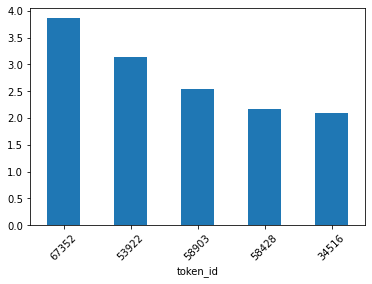

In [ ]:
EIG_PAIRS.exp_var.sort_values(ascending=False).head().plot.bar(rot=45)

In [ ]:
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
COMPS

,eig_val,52419,51974,48558,52396,37625,31143,2284,14491,10625,...,51328,57372,61210,11996,34516,58428,58903,53922,67352,exp_var
PC0,1.605341e-06,-0.003759,0.009453,0.007336,-0.002211,0.006995,0.008421,-0.026060,-0.614074,0.007500,...,0.000717,-0.001479,-0.007496,0.000743,0.000919,-0.003341,0.000817,0.000377,0.000927,3.86
PC1,1.307528e-06,0.011226,0.014286,0.004050,0.008810,0.007952,-0.000509,0.002293,-0.030219,0.007025,...,0.000701,0.000500,0.000504,0.000403,0.000952,0.000233,0.001362,0.000973,0.000846,3.14
PC2,1.058975e-06,-0.026028,0.043260,0.021882,-0.029002,0.020414,-0.070227,-0.067178,-0.006681,-0.156285,...,0.003461,-0.001040,0.002574,0.003422,0.001356,-0.003370,0.003894,-0.000690,0.001872,2.54
PC3,9.007145e-07,-0.026047,0.016396,0.002645,-0.019651,0.001673,-0.068001,-0.061708,0.026554,0.007396,...,0.005414,-0.002051,0.001790,0.002984,-0.000387,-0.008252,0.000757,0.000629,0.000114,2.16
PC4,8.680258e-07,-0.023058,0.028552,0.013035,-0.016558,0.016524,-0.079273,-0.067812,-0.007987,-0.011993,...,-0.001340,-0.009931,0.002560,0.001493,0.002196,-0.008508,0.011131,-0.002214,0.001201,2.09
PC5,8.121580e-07,0.009588,0.027661,0.007838,0.038145,0.055252,-0.012558,-0.011916,0.003931,-0.023365,...,-0.001306,-0.006044,0.000526,-0.001342,-0.002068,-0.004634,-0.016962,0.001069,-0.000856,1.95
PC6,7.943276e-07,-0.009528,-0.059187,-0.027300,0.007575,-0.006564,0.001721,-0.000996,0.004600,-0.006650,...,-0.001278,0.000260,0.000694,-0.001787,0.000746,-0.000633,0.032400,0.000223,-0.001682,1.91
PC7,7.821050e-07,-0.001810,0.058522,0.031905,0.002859,0.008154,0.003958,0.004761,-0.001974,-0.004790,...,0.001200,-0.008568,-0.004149,0.000564,0.002373,-0.002456,0.003721,-0.000607,0.000252,1.88
PC8,7.368358e-07,-0.024061,-0.065937,-0.027151,-0.012842,-0.023684,-0.011057,-0.012431,0.008976,-0.002528,...,0.000185,0.002641,-0.000839,-0.000270,-0.001167,0.001083,0.009747,-0.001426,0.000056,1.77
PC9,7.056656e-07,-0.009931,0.148296,0.048762,-0.001506,0.031209,-0.054272,-0.056176,0.003674,-0.004054,...,0.000962,0.006803,0.001590,0.002100,0.001298,0.004881,-0.000798,0.000626,0.000547,1.70


In [ ]:
LOADINGS = COMPS[TERM_IDX].T
LOADINGS.index.name = 'term_id'
VOCAB = VOCAB.merge(LOADINGS, left_index=True, right_index=True, how='outer').fillna(0)
VOCAB.sort_values(by='PC0', ascending=False)

,token,count,num,stop,p_stem,pos_max,count_rank,alt_rank,p,p2,...,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
32623,blo,75,0,0,blo,NN,2785,874,0.001081,0.000029,...,0.035174,-0.739785,-0.006490,0.023563,0.022852,0.021177,0.013081,0.000685,-0.002932,-0.017548
61277,sleeves,95,0,0,sleev,NNS,2285,854,0.001370,0.000036,...,0.020232,-0.416652,-0.002714,0.013233,0.013692,0.011979,0.006291,0.001533,-0.002355,-0.008789
62180,spikes,49,0,0,spike,NNS,3816,900,0.000706,0.000019,...,0.013495,-0.280286,-0.001973,0.009294,0.008823,0.008035,0.004649,0.000472,-0.001165,-0.006381
52601,noided,27,0,0,noid,JJ,5994,922,0.000389,0.000010,...,0.012663,-0.266323,-0.002336,0.008483,0.008227,0.007624,0.004709,0.000246,-0.001055,-0.006317
69242,yuh,165,0,0,yuh,NN,1487,784,0.002379,0.000063,...,0.012344,-0.146763,-0.075760,-0.074065,-0.114121,-0.048172,0.013498,-0.041729,0.025777,0.052318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7700,Dip,94,0,0,dip,NNP,2320,855,0.001355,0.000036,...,-0.089609,-0.000100,-0.007256,-0.025449,0.003265,-0.005292,-0.002705,-0.001151,-0.009855,-0.012164
22588,Santana,56,0,0,santana,NNP,3471,893,0.000807,0.000021,...,-0.115665,-0.002589,-0.008933,-0.026855,0.001885,-0.005742,-0.001336,-0.001181,-0.008811,-0.018518
7711,Dipset,109,0,0,dipset,NNP,2053,840,0.001572,0.000042,...,-0.447823,-0.020453,-0.019455,-0.038313,0.017622,-0.000916,0.001029,-0.003573,-0.000857,-0.006116
13718,Jeah,76,0,0,jeah,NNP,2751,873,0.001096,0.000029,...,-0.590407,-0.030960,-0.017840,-0.023069,0.027776,0.007662,0.002873,-0.002720,0.010905,0.008197


In [ ]:
DCM = TFIDF_sub.dot(COMPS[TERM_IDX].T)
DCM.to_csv('data/tables/DCM.csv')
DCM

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
artist,,,,,,,,,,
2 Chainz,0.000022,7.801102e-05,-0.000370,-0.000362,-0.000396,0.000028,-0.000024,0.000074,-0.000133,-0.000196
21 Savage,0.000281,3.479604e-04,-0.011547,0.004269,0.002863,-0.000187,-0.000132,-0.000055,0.000192,0.000435
2Pac,0.000012,9.640216e-06,0.000045,0.000009,0.000034,0.000084,-0.000073,0.000047,-0.000075,0.000060
50 Cent,-0.000039,-3.767146e-05,-0.000092,-0.000027,-0.000049,0.000061,-0.000018,0.000026,-0.000076,0.000022
A Boogie wit da Hoodie,0.000018,3.071630e-05,-0.000224,-0.000131,-0.000157,0.000032,0.000021,0.000035,-0.000064,-0.000128
...,...,...,...,...,...,...,...,...,...,...
YG,0.000091,2.242466e-04,-0.000751,-0.000902,-0.000956,0.004931,0.002328,-0.000154,0.000183,-0.000118
Yasiin Bey,-0.000004,3.613095e-07,0.000107,0.000105,0.000045,-0.000045,-0.000045,-0.000048,0.000016,0.000061
Young Thug,0.000003,9.633284e-05,-0.001058,-0.000894,-0.000992,0.000049,0.000081,0.000005,-0.000203,-0.000956


In [ ]:
LOADINGS = COMPS[TERM_IDX].T
LOADINGS.index.name = 'token_id'
LOADINGS['token'] = LOADINGS.apply(lambda x: VOCAB.loc[int(x.name)].token, 1)

l0_pos = LOADINGS.sort_values('PC0', ascending=True).head(10).token.str.cat(sep=' ')
l0_neg = LOADINGS.sort_values('PC0', ascending=False).head(10).token.str.cat(sep=' ')
l1_pos = LOADINGS.sort_values('PC1', ascending=True).head(10).token.str.cat(sep=' ')
l1_neg = LOADINGS.sort_values('PC1', ascending=False).head(10).token.str.cat(sep=' ')

print('Terms PC0+', l0_pos)
print('Terms PC0-', l0_neg)
print('Terms PC1+', l1_pos)
print('Terms PC1-', l1_neg)

Terms PC0+ Killa Jeah Dipset Santana Dip Juelz Curtis oww moving getback
Terms PC0- blo sleeves spikes noided yuh issa Issa 21 na Whoop
Terms PC1+ blo sleeves spikes noided yuh footage Spikes shock Hustle Yuh
Terms PC1- Whoop issa na Issa 21 niggas Lyte nigga brazy da


## LDA

In [343]:
def gibbs_sample(d, w):
    
    global n_topics, n_docs, n_words, BOW, PHI, THETA, alpha, beta, topic_names
    
    # Get current topic for word in doc
    z1 = BOW.at[(d, w), 'topic_id']
    
    # Get the number of tokens for the word
    n = BOW.at[(d, w), 'n']
    
    # Remove current assignment from the counts
    PHI.at[w, z1] -= n
    THETA.at[z1, d] -= n

    # Sample from the two count matrices
    weights = np.zeros(n_topics)
    for t in topic_names:
        
        # How much this word is currently labeled by each topic
        P = (PHI.at[w, t] + alpha) / (PHI[t].sum() + n_words * alpha)
        
        # How much each topic currently appears in this document
        T = (THETA.at[t, d] + beta) / (THETA[d].sum() + n_topics * beta)
        
        # The combined value of P and T.
        weights[t] = P * T

    # Draw new topic value from weighted list of topics
    pwgt = weights / weights.sum()
    z2 = np.random.choice(topic_names, p=pwgt)
    
    # Apply the value of the word to the topic  
    PHI.at[w, z2] += n
    THETA.at[z2, d] += n
        
    # Update the topic assignment
    BOW.at[(d , w), 'topic_id'] = z2
    
def show_results():
    
    global VOCAB, TOPIC, THETA, PHI, topic_names
        
    P = PHI[topic_names] / PHI[topic_names].sum()
    
    P['term_str'] = VOCAB.token 
    for t in topic_names:
        top_terms = P.sort_values(t, ascending=False).head(10)[[t, 'term_str']]
        print('-' * 80)
        print(top_terms)
        # Could add a string to TOPIC.loc[t, 'top_terms'] to demonstrate use of tables to capture information.
    
    print('-' * 80)
    
    DOC = THETA.T
    print(DOC.head(1000))
    
    print('-' * 80)

In [356]:
TOKEN_sub.loc[TOKEN_sub.token.str.len() > 4]

temp      token  \
artist     song_id verse_num line_num token_num                                
Aesop Rock 0       1         0        1               (trust, NN)      trust   
                             1        1               (trust, NN)      trust   
                   2         0        0               (Flash, NN)      Flash   
                             1        1           (zeitgeist, NN)  zeitgeist   
                                      2              (wither, NN)     wither   
...                                                           ...        ...   
NF         3974    3         20       3           (something, NN)  something   
                             22       7          (questions, NNS)  questions   
                             23       3              (search, NN)     search   
                                      9            (answers, NNS)    answers   
                             24       6             (things, NNS)     things   

                                                 pos  token_id  
artist     song_id verse_num line_num token_num                 
Aesop Rock 0       1         0        1           NN     65960  
                             1        1           NN     65960  
                   2         0        0           NN      9862  
                             1        1           NN     69277  
                                      2           NN     68538  
...                                              ...       ...  
NF         3974    3         20       3           NN     61835  
                             22       7          NNS     56909  
                             23       3           NN     59717  
                                      9          NNS     30301  
                             24       6          NNS     64735  

[303103 rows x 4 columns]

In [413]:
%%time
n_topics = 5
n_iters = 100
alpha = .05
beta = .4

# exclude certain tokens and stopwords
#exclude = ['nigga','niggas','bitch','shit','fuck','yeah','aint','em','ya','youre','way','yall','thats','cause']
exclude = ['yeah','aint','em','ya','youre','way','yall','thats','cause']
TOKEN_sub = TOKEN.loc[-(TOKEN.token_id.isin(VOCAB.loc[VOCAB.stop == 1].index)) &
                      TOKEN.pos.str.match(r'^NNS?$') &
                      -(TOKEN.token.str.lower().isin(exclude)) &
                      (TOKEN.token.str.len() > 4)]

# create BOW and remove terms that almost never show up
BOW = TOKEN_sub.groupby(['artist', 'token_id']).token_id.count().to_frame().rename(columns={'token_id':'n'})
BOW = BOW.loc[BOW.n > 5]

# Create TOPIC table
TOPIC = pd.DataFrame(index=range(n_topics))
TOPIC.index.name = 'topic_id'
topic_names = TOPIC.index.tolist()

# Randomly assign topics to words (word = term in BOW)
BOW['topic_id'] = TOPIC.sample(BOW.shape[0], replace=True).index

# Generete topic-doc count matrix
THETA = BOW.groupby(['topic_id', 'artist']).n.sum().unstack().fillna(0).astype('int')

# Generate term-topic matrix (aka word-topic)
PHI = BOW.groupby(['token_id', 'topic_id']).n.sum().unstack().fillna(0).astype('int')  

# Get doc and word counts
n_docs = THETA.shape[1]
n_words = PHI.shape[0]

Wall time: 2.87 s


In [414]:
# build
for i in tqdm(range(n_iters)):
    BOW.apply(lambda x: gibbs_sample(x.name[0], x.name[1]), 1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:48<00:00,  4.68s/it]


In [415]:
show_results()

--------------------------------------------------------------------------------
topic_id         0      term_str
token_id                        
52396     0.104176         nigga
32336     0.089391         bitch
51415     0.050856         money
52449     0.043463         night
32343     0.033862       bitches
46195     0.028848         house
58512     0.021838         right
51611     0.021626  motherfucker
52576     0.018057        nobody
56791     0.014870         pussy
--------------------------------------------------------------------------------
topic_id         1 term_str
token_id                   
51415     0.040517    money
52449     0.031208    night
58512     0.027793    right
43831     0.026989    girls
63248     0.024712    style
44065     0.023507    gonna
58386     0.019622    rhyme
58392     0.018752   rhymes
46195     0.018216    house
43096     0.017345   friend
--------------------------------------------------------------------------------
topic_id         2   term

In [416]:
DTopM = (THETA / THETA.sum()).T
DTopM.to_csv('data/tables/DTopM.csv')
DTopM.sort_values(by=[0], ascending=False)

topic_id,0,1,2,3,4
artist,,,,,
YG,0.825355,0.000000,0.000000,0.132979,0.041667
​cupcakKe,0.727273,0.000000,0.132231,0.140496,0.000000
Three 6 Mafia,0.723135,0.108723,0.000000,0.000000,0.168142
Danny Brown,0.679920,0.000000,0.027833,0.143141,0.149105
Vince Staples,0.668113,0.000000,0.156182,0.075922,0.099783
...,...,...,...,...,...
Skyzoo,0.000000,0.363636,0.128788,0.492424,0.015152
RZA,0.000000,0.265455,0.265455,0.381818,0.087273
Blackalicious,0.000000,0.298932,0.252669,0.279359,0.169039


In [419]:
PHI_pct = (PHI / PHI.sum()).rename(columns={0:'T0%', 1:'T1%', 2:'T2%' ,3:'T3%', 4:'T4%'})*100
PHI_results = PHI.rename(columns={0:'T0', 1:'T1', 2:'T2' ,3:'T3', 4:'T4'}).merge(PHI_pct, left_index=True, right_index=True)
#PHI_results.to_csv('data/tables/PHI_results.csv')
PHI_results

topic_id,T0,T1,T2,T3,T4,T0%,T1%,T2%,T3%,T4%
token_id,,,,,,,,,,
1181,0,0,0,8,0,0.000000,0.000000,0.000000,0.032108,0.000000
1319,0,10,0,0,0,0.000000,0.066970,0.000000,0.000000,0.000000
1469,0,0,6,0,0,0.000000,0.000000,0.041794,0.000000,0.000000
1554,0,67,0,0,0,0.000000,0.448701,0.000000,0.000000,0.000000
1581,0,0,14,0,0,0.000000,0.000000,0.097520,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
69221,0,0,0,0,7,0.000000,0.000000,0.000000,0.000000,0.030088
69281,0,0,0,6,0,0.000000,0.000000,0.000000,0.024081,0.000000
69296,0,0,14,0,0,0.000000,0.000000,0.097520,0.000000,0.000000


In [420]:
VOCAB.merge(PHI_results.reset_index(), left_index=True, right_index=True, how='outer').fillna(0)

,token,count,num,stop,p_stem,pos_max,count_rank,alt_rank,p,p2,...,T0,T1,T2,T3,T4,T0%,T1%,T2%,T3%,T4%
0,0,11,1,0,0,CD,11149,938,0.000159,4.204523e-06,...,0.0,0.0,0.0,8.0,0.0,0.0,0.000000,0.000000,0.032108,0.0
1,007,1,1,0,007,VBZ,59654,948,0.000014,3.822294e-07,...,0.0,10.0,0.0,0.0,0.0,0.0,0.066970,0.000000,0.000000,0.0
2,01,1,1,0,01,CD,54414,948,0.000014,3.822294e-07,...,0.0,0.0,6.0,0.0,0.0,0.0,0.000000,0.041794,0.000000,0.0
3,02,4,1,0,02,CD,20856,945,0.000058,1.528918e-06,...,0.0,67.0,0.0,0.0,0.0,0.0,0.448701,0.000000,0.000000,0.0
4,03,7,1,0,03,CD,15341,942,0.000101,2.675606e-06,...,0.0,0.0,14.0,0.0,0.0,0.0,0.000000,0.097520,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69355,zuke,1,0,0,zuke,NN,38033,948,0.000014,3.822294e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
69356,zum,1,0,0,zum,NN,38019,948,0.000014,3.822294e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
69357,zutto,4,0,0,zutto,NN,21000,945,0.000058,1.528918e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
69358,zygote,2,0,0,zygot,NN,30966,947,0.000029,7.644588e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


## Word Embedding

In [454]:
def complete_analogy(model, A, B, C, n=2):
    try:
        return model.wv.most_similar(positive=[B, C], negative=[A])[0:n]
    except KeyError as e:
        print('Error:', e)
        return None

In [468]:
window = 5

corpus = TOKEN.loc[~TOKEN.pos.str.match('NNPS?')].groupby(OHCO[:3]).token.apply(lambda  x:  x.tolist()).reset_index()['token'].tolist()
model = word2vec.Word2Vec(corpus, vector_size=246, window=window, min_count=200, workers=4)

coords = pd.DataFrame(index=range(len(model.wv.key_to_index)))
coords['label'] = [w for w in model.wv.key_to_index]
coords['vector'] = coords['label'].apply(lambda x: model.wv.get_vector(x))

tsne_model = TSNE(perplexity=20, n_components=2, init='pca', n_iter=1500, random_state=23)
tsne_values = tsne_model.fit_transform(coords['vector'].tolist())

coords['x'] = tsne_values[:,0]
coords['y'] = tsne_values[:,1]
coords.head()

C:\Users\cschr\anaconda3\envs\pythonenv-nlp\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

C:\Users\cschr\anaconda3\envs\pythonenv-nlp\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



,label,vector,x,y
0,the,"[-0.024757462, 0.039259955, 0.53996974, 0.3807...",-25.669622,13.383431
1,I,"[-0.23231201, -0.34231254, 0.22460608, -0.3476...",34.844589,-25.172380
2,a,"[0.5493972, 0.5186788, 0.2975549, -0.60569423,...",-1.154997,-3.182287
3,you,"[-0.020271622, 0.7700379, 0.8291161, -0.119129...",35.030304,-15.009844
4,to,"[-0.1677655, -0.3359684, 0.07899949, -0.451866...",9.363723,17.709015


In [465]:
#coords.to_csv('data/tables/wordEmbeddings.csv')

In [467]:
complete_analogy(model, 'dude', 'house', 'death')

[('rest', 0.4993184506893158), ('zone', 0.4869772493839264)]

## Sentiment Analysis

In [475]:
TOKEN2

temp   token  pos  \
artist   song_id verse_num line_num token_num                               
The Game 1987    2         21       5              (and, CC)     and   CC   
                                    6             (fuck, VB)    fuck   VB   
                                    7            (these, DT)   these   DT   
                                    8            (fuck, NNS)    fuck  NNS   
                                    9          (niggas, VBP)  niggas  VBP   
...                                                      ...     ...  ...   
NF       3974    3         25       4             (many, JJ)    many   JJ   
                                    5           (faces, VBZ)   faces  VBZ   
                                    6              (too, RB)     too   RB   
                                    7             (many, JJ)    many   JJ   
                                    8           (faces, VBZ)   faces  VBZ   

                                               token_id  
artist   song_id verse_num line_num token_num            
The Game 1987    2         21       5             30198  
                                    6             43211  
                                    7             64679  
                                    8             43211  
                                    9             52419  
...                                                 ...  
NF       3974    3         25       4             50209  
                                    5             41479  
                                    6             65322  
                                    7             50209  
                                    8             41479  

[1308115 rows x 4 columns]

In [478]:
TOKEN1

temp  token  pos  \
artist     song_id verse_num line_num token_num                             
Aesop Rock 0       1         0        0             (Im, NNP)     Im  NNP   
                                      1           (trust, NN)  trust   NN   
                                      2             (me, PRP)     me  PRP   
                                      3             (Im, NNP)     Im  NNP   
                                      4           (trust, VB)  trust   VB   
...                                                       ...    ...  ...   
The Game   1987    2         21       0            (Ayy, NNP)    Ayy  NNP   
                                      1          (Frank, NNP)  Frank  NNP   
                                      2          (Ocean, NNP)  Ocean  NNP   
                                      3             (go, VBP)     go  VBP   
                                      4           (ahead, RB)  ahead   RB   

                                                 token_id  
artist     song_id verse_num line_num token_num            
Aesop Rock 0       1         0        0             13019  
                                      1             65960  
                                      2             50477  
                                      3             13019  
                                      4             65960  
...                                                   ...  
The Game   1987    2         21       0              2284  
                                      1             10192  
                                      2             18539  
                                      3             43982  
                                      4             29786  

[1308115 rows x 4 columns]